In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
ob = pd.read_csv("Grid.csv", header=None)

In [3]:
rows,cols = np.where(ob.values>0)

In [4]:
obstacles = np.column_stack((rows,cols)).tolist()

In [6]:
ob = pd.read_csv("Grid.csv", header=None)
cols, rows = np.where(ob.values>0)
obstacles = np.column_stack((rows,cols)).tolist()
list_of_tuples = [tuple(sublist) for sublist in obstacles]
print(list_of_tuples)

[(0, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (0, 1), (6, 1), (7, 1), (13, 1), (17, 1), (21, 1), (23, 1), (27, 1), (29, 1), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (7, 2), (9, 2), (11, 2), (15, 2), (19, 2), (21, 2), (25, 2), (29, 2), (0, 3), (4, 3), (5, 3), (7, 3), (9, 3), (13, 3), (17, 3), (21, 3), (23, 3), (25, 3), (27, 3), (29, 3), (0, 4), (2, 4), (5, 4), (7, 4), (9, 4), (11, 4), (15, 4), (19, 4), (21, 4), (23, 4), (25, 4), (27, 4), (29, 4), (0, 5), (2, 5), (3, 5), (5, 5), (7, 5), (9, 5), (13, 5), (17, 5), (21, 5), (23, 5), (27, 5), (29, 5), (0, 6), (3, 6), (7, 6), (9, 6), (11, 6), (15, 6), (19, 6), (21, 6), (25, 6), (29, 6), (0, 7), (1, 7), (3, 7), (4, 7), (5, 7), (6, 7), (7, 7), (9, 7), (13, 7), (17, 7), (21, 7), (23, 7), (25, 7), (27, 7), (29, 7), (0, 8), (1, 8), (9, 8), (11, 

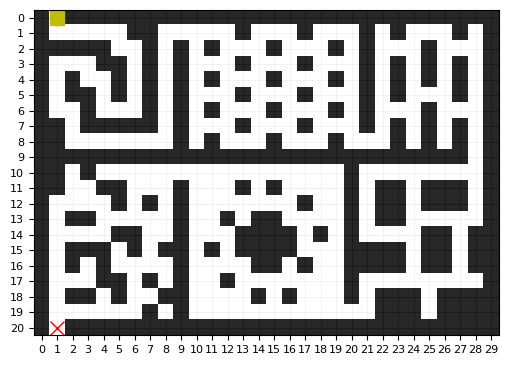

In [7]:
class GridWorld:
    def __init__(self, size=(21, 30),list_obstacles=list_of_tuples):
        self.size = size
        self.start_state = (1, 0)
        self.path = [self.start_state]
        self.goal_state = (1, 20)
        self.obstacles = list_obstacles
        self.grid = np.zeros([self.size[0],self.size[1]],dtype=int)
        self.cols, self.rows = zip(*self.obstacles)
        self.grid[self.rows,self.cols]=1
        self.reset()

    def reset(self):
        self.agent_position = self.start_state
        return self.agent_position

    def step(self, action):
        x, y = self.agent_position
        if action == 0:   # Left
            x -= 1
        elif action == 1: # Right
            x += 1
        elif action == 2: # Up
            y -= 1
        elif action == 3: # Down
            y += 1

        # we need to clip to the bounds of the maze
        x = np.clip(x, 0, self.size[1] - 1)
        y = np.clip(y, 0, self.size[0] - 1)

        new_position = (x, y)
        if new_position in self.obstacles:
            new_position = self.agent_position
            # a good idea is to provide a negative reward when the agent is hitting an obstacle
            reward = -0.5
        else:
            reward = -0.1

        self.agent_position = new_position

        if self.agent_position == self.goal_state:
            reward = 10
            done = True
        else:
            done = False

        self.path.append(new_position)

        return new_position, reward, done

    def render(self, final_path):
        grid_render = plt.figure(figsize=(6,6)) #Create a figure
        plt.imshow(self.grid, cmap='binary',zorder=2,alpha=0.85) #Render the obstacles
        if final_path:
            plt.plot(np.array(final_path)[:,0], np.array(final_path)[:,1], '-m', linewidth = 4) #Plot the agent path
        plt.plot(self.start_state[0],self.start_state[1], 'ob', markersize=10) #Plot the starting position
        plt.plot(self.goal_state[0],self.goal_state[1], 'xr', markersize=10) #Plot the exit position
        plt.xticks(np.arange(0,self.size[1]),fontsize=8)
        plt.yticks(np.arange(0,self.size[0]),fontsize=8)
        # plt.plot(np.array(self.checkpoints)[:,0], np.array(self.checkpoints)[:,1], 'xb', markersize=5) #Plot the checkpoints
        plt.plot(self.agent_position[0], self.agent_position[1], 'sy', markersize=10) #Plot the agent's current position
        plt.grid(True,zorder=0)
        # print(f"Steps: {self.steps}, Score: {self.score}, Exitted: {self.exitted}") #Print out results

env = GridWorld() # we instantiated the object
env.render(None)

In [8]:
# Here is the actual training of the agent via MDP processes
# Initialize Q-table
q_table = np.zeros((env.size[1], env.size[0], 4))

# Hyperparameters
alpha = 0.1   # Learning rate
gamma = 0.99  # Discount factor
epsilon = 0.25 # Exploration rate

# Training the agent
num_episodes = 1500
nr_of_steps = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    step = 0
    while not done and step<env.size[1]**2:

        # here we implement the epsilon-greedy strategy
        if random.uniform(0, 1) < epsilon:
            action = random.choice([0, 1, 2, 3]) # Explore
        else:
            action = np.argmax(q_table[state[0], state[1]]) # Exploit

        next_state, reward, done = env.step(action)
        best_next_action = np.argmax(q_table[next_state[0], next_state[1]])
        # here we apply the Bellman's equation for updating the Q-value table 
        q_table[state[0], state[1], action] = q_table[state[0], state[1], action] + \
            alpha * (reward + gamma * q_table[next_state[0], next_state[1], best_next_action] - q_table[state[0], state[1], action])
        step += 1
        state = next_state
    nr_of_steps.append(step)

print("Training complete!")

Training complete!


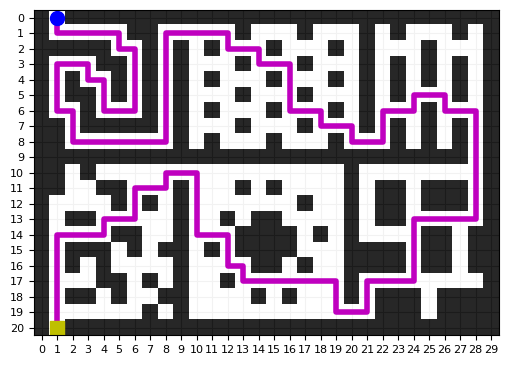

In [9]:
state = env.reset()
done = False
positions = [state]

while not done:
    action = np.argmax(q_table[state[0], state[1]]) # this is yielding a path (hopefully) to the goal
    next_state, _, done = env.step(action)
    positions.append(next_state)
    state = next_state

env.render(positions)

---

In [3]:
class GridWorld:
    def __init__(self, size=(21, 30), list_obstacles=list_of_tuples):
        self.size = size
        self.start_state = (0, 1)
        self.goal_state = (20, 1)
        self.obstacles = list_obstacles
        self.path = []
        self.reset()

    def reset(self):
        self.agent_position = self.start_state
        self.path = []
        return self.agent_position

    def step(self, action):
        x, y = self.agent_position
        if action == 0:   # Up
            x -= 1
        elif action == 1: # Down
            x += 1
        elif action == 2: # Left
            y -= 1
        elif action == 3: # Right
            y += 1

        x = np.clip(x, 0, self.size[0] - 1)
        y = np.clip(y, 0, self.size[1] - 1)

        new_position = (x, y)
        if new_position in self.obstacles:
            new_position = self.agent_position # penalize moving into obstacle
            reward = -0.5
        elif new_position in self.path: # penalize moving backwards on the same path
            reward = -0.2
        else:
            reward = -0.1

        self.agent_position = new_position
        self.path.append(new_position)

        if self.agent_position == self.goal_state:
            reward = 10.0
            done = True
        else:
            done = False

        return new_position, reward, done

env = GridWorld()

# Initialize Q-table
q_table = np.zeros((env.size[0], env.size[1], 4))
n_table = np.zeros((env.size[0], env.size[1], 4))

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
c = 2.0      # Degree of exploration for UCB

def select_action(state, episode):
    ucb_values = q_table[state[0], state[1]] + c * np.sqrt(np.log(episode + 1) / (n_table[state[0], state[1]] + 1e-5))
    return np.argmax(ucb_values)

# Training the agent
num_episodes = 2000
max_steps_per_episode = env.size[0] * env.size[1]

print("Training agent...")
for episode in range(num_episodes):
    state = env.reset()
    done = False
    steps = 0
    while not done and steps < max_steps_per_episode:
        action = select_action(state, episode)
        n_table[state[0], state[1], action] += 1
        next_state, reward, done = env.step(action)
        best_next_action = np.argmax(q_table[next_state[0], next_state[1]])
        q_table[state[0], state[1], action] = q_table[state[0], state[1], action] + \
            alpha * (reward + gamma * q_table[next_state[0], next_state[1], best_next_action] - q_table[state[0], state[1], action])

        state = next_state
        steps += 1

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed")

print("Training complete!")

# Test the trained agent and collect data for animation
state = env.reset()
done = False
positions = [state]
steps = 0 # Reset steps counter before testing!

while not done and steps < max_steps_per_episode:
    action = np.argmax(q_table[state[0], state[1]])
    next_state, _, done = env.step(action)
    positions.append(next_state)
    state = next_state
    steps += 1

# Debugging: Print the positions
print("Final path taken by the agent:")
print(f"Start: {env.start_state} -> Goal: {env.goal_state}")
print(f"Path length: {len(positions)} steps")
print("Path coordinates (x, y):", positions)

Training agent...
Episode 100/2000 completed
Episode 200/2000 completed
Episode 300/2000 completed
Episode 400/2000 completed
Episode 500/2000 completed
Episode 600/2000 completed
Episode 700/2000 completed
Episode 800/2000 completed
Episode 900/2000 completed
Episode 1000/2000 completed
Episode 1100/2000 completed
Episode 1200/2000 completed
Episode 1300/2000 completed
Episode 1400/2000 completed
Episode 1500/2000 completed
Episode 1600/2000 completed
Episode 1700/2000 completed
Episode 1800/2000 completed
Episode 1900/2000 completed
Episode 2000/2000 completed
Training complete!
Final path taken by the agent:
Start: (0, 1) -> Goal: (20, 1)
Path length: 141 steps
Path coordinates (x, y): [(0, 1), (np.int64(1), np.int64(1)), (np.int64(1), np.int64(2)), (np.int64(1), np.int64(3)), (np.int64(1), np.int64(4)), (np.int64(1), np.int64(5)), (np.int64(2), np.int64(5)), (np.int64(2), np.int64(6)), (np.int64(3), np.int64(6)), (np.int64(4), np.int64(6)), (np.int64(5), np.int64(6)), (np.int64(6),

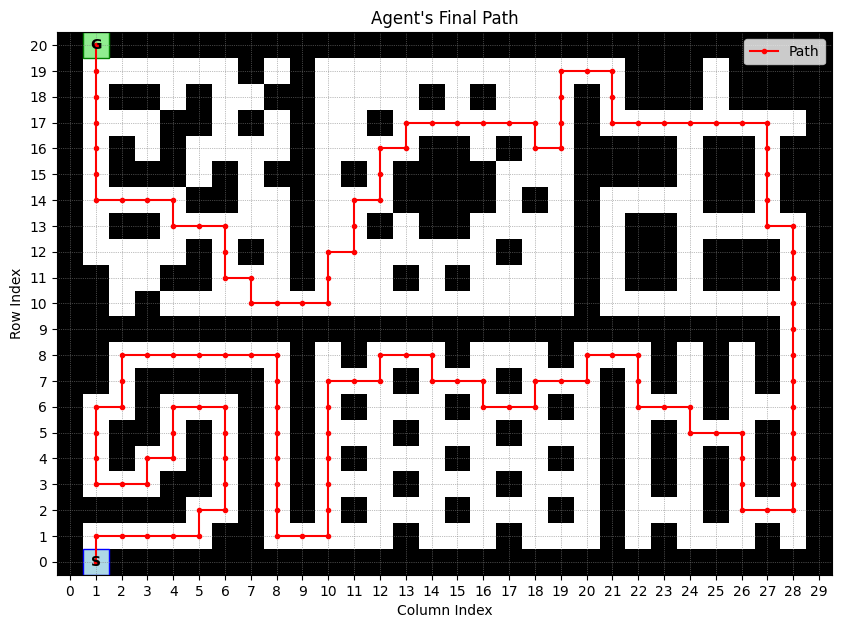

In [5]:
def plot_results(env, path):
    fig, ax = plt.subplots(figsize=(10, 12))
    ax.set_aspect('equal', adjustable='box')

    # Set axis limits. Your grid is (rows, cols), so we set the plot
    # to have columns on the x-axis and rows on the y-axis.
    ax.set_xlim(-0.5, env.size[1] - 0.5)
    ax.set_ylim(-0.5, env.size[0] - 0.5)
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    ax.set_title("Agent's Final Path")


    for obs in env.obstacles:
        row, col = obs
        rect = patches.Rectangle((col - 0.5, row - 0.5), 1, 1, facecolor='black')
        ax.add_patch(rect)

    
    start_row, start_col = env.start_state
    goal_row, goal_col = env.goal_state
    start_patch = patches.Rectangle((start_col - 0.5, start_row - 0.5), 1, 1, facecolor='lightblue', edgecolor='blue')
    goal_patch = patches.Rectangle((goal_col - 0.5, goal_row - 0.5), 1, 1, facecolor='lightgreen', edgecolor='green')
    ax.add_patch(start_patch)
    ax.add_patch(goal_patch)
    ax.text(start_col, start_row, 'S', ha='center', va='center', fontweight='bold', color='black')
    ax.text(goal_col, goal_row, 'G', ha='center', va='center', fontweight='bold', color='black')

    # Draw the agent's path as a red line
    if path:
        path_rows = [p[0] for p in path]
        path_cols = [p[1] for p in path]
        ax.plot(path_cols, path_rows, marker='o', markersize=3, linestyle='-', color='red', label='Path')

    # Add grid lines for better readability
    ax.set_xticks(np.arange(env.size[1]))
    ax.set_yticks(np.arange(env.size[0]))
    ax.grid(which='both', color='gray', linestyle=':', linewidth=0.5)
    ax.legend(loc='upper right')
    plt.show()

# Call the new function to show the plot
plot_results(env, positions)

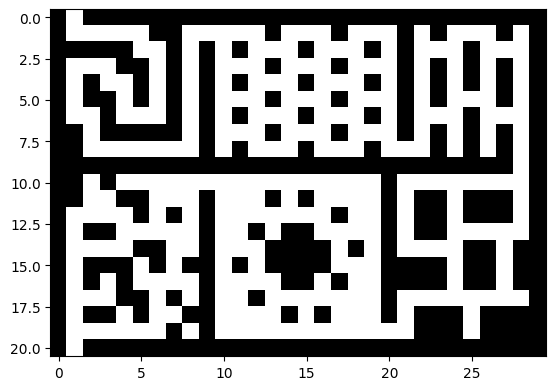

In [24]:
plt.imshow(ob.values,cmap ='binary')